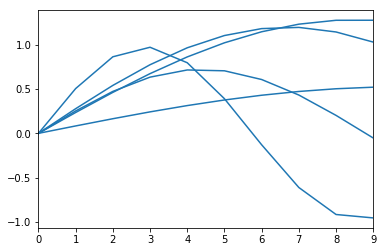

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd

SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

for i in range(5):
  sns.tsplot( create_time_series() );  # 5 series

In [10]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [11]:
import tensorflow as tf
import shutil
from tensorflow.contrib.learn import ModeKeys
import tensorflow.contrib.rnn as rnn

In [12]:
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

In [13]:
def read_dataset(filename, mode=ModeKeys.TRAIN):
  def _input_fn():
    num_epochs = 100 if mode == ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    

    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    value_column = tf.expand_dims(value, -1, name='value')
    print('readcsv={}'.format(value_column))
    
    # all_data is a list of tensors
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
    inputs = all_data[:len(all_data)-N_OUTPUTS]  # first few values
    label = all_data[len(all_data)-N_OUTPUTS : ] # last few values
    
    # from list of tensors to tensor with one more dimension
    inputs = tf.concat(inputs, axis=1)
    label = tf.concat(label, axis=1)
    print('inputs={}'.format(inputs))

    return {TIMESERIES_COL: inputs}, label   # dict of features, label

  return _input_fn

In [14]:


LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, labels, mode, params):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
  #print 'x={}'.format(x)
    
  # 1. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

  # slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  #print 'last outputs={}'.format(outputs)
  
  # output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. loss function, training/eval ops
  if mode == ModeKeys.TRAIN or mode == ModeKeys.EVAL:
     loss = tf.losses.mean_squared_error(labels, predictions)
     train_op = tf.contrib.layers.optimize_loss(
         loss=loss,
         global_step=tf.train.get_global_step(),
         learning_rate=0.01,
         optimizer="SGD")
     eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
     }
  else:
     loss = None
     train_op = None
     eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}

  # 4. Create export outputs  
  export_outputs = {"predicted": tf.estimator.export.PredictOutput(predictions)}

  # 5. return ModelFnOps
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs=export_outputs)



In [15]:
def get_train():
  return read_dataset('train.csv', mode=ModeKeys.TRAIN)

def get_valid():
  return read_dataset('valid.csv', mode=ModeKeys.EVAL)

def serving_input_receiver_fn():
  feature_placeholders = {
    TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }

  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }

  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2], name='timeseries')
  
  print('serving: features={}'.format(features[TIMESERIES_COL]))

  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)


def experiment_fn(output_dir):
  train_spec = tf.estimator.TrainSpec(input_fn=get_train(), max_steps=1000)
  exporter = tf.estimator.FinalExporter('timeseries',
    serving_input_receiver_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn=get_valid(), 
    exporters=[exporter])

  estimator = tf.estimator.Estimator(model_fn=simple_rnn, model_dir=output_dir)

  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

OUTPUT_DIR = 'outputdir'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True) # start fresh each time

experiment_fn(OUTPUT_DIR)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f44eff347f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start t